# Load Module

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator

from sklearn.metrics import auc, roc_curve, classification_report

%matplotlib inline

# Load Dataset

In [4]:
df = pd.read_csv('/Users/xiaolingliu/Google_Drive/case/Collections_of_DS_FULL/Datasets/ConversionRates/conversion_project.csv')
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [6]:
df.describe(include = 'all')

,country,age,new_user,source,total_pages_visited,converted
count,316200,316200.000000,316200.000000,316200,316200.000000,316200.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,178092,NaN,NaN,155040,NaN,NaN
mean,NaN,30.569858,0.685465,NaN,4.872966,0.032258
std,NaN,8.271802,0.464331,NaN,3.341104,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


In [7]:
print(df['country'].value_counts())
print('\t')
print(df['source'].value_counts())

US         178092
China       76602
UK          48450
Germany     13056
Name: country, dtype: int64
	
Seo       155040
Ads        88740
Direct     72420
Name: source, dtype: int64


# Remove Outliers

In [8]:
df[df['age'] > 90]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


### The maximun age is 123, which is strange and worrisome. Here I will just remove the data since there is only 2 records with strange age input. However, this can be an indicator of some bug in the logging code. Therefore, I would talk to the software engineer who implemented the code to see, if, perhaps, there are some bugs which affect the data significantly.

In [9]:
df = df[df['age'] <= 90]

In [52]:
df.describe()

,age,new_user,total_pages_visited,converted
count,316198.000000,316198.000000,316198.000000,316198.000000
mean,30.569311,0.685469,4.872918,0.032252
std,8.268958,0.464329,3.341053,0.176669
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,79.000000,1.000000,29.000000,1.000000


### A few quick observations:
#### 1. The site is probably a US site, although it does have a large Chinese user base as well.
#### 2. User base is pretty young.
#### 3. Conversion rate is 3%, which is industry standard. It makes sense.

# Exploratory Data Analysis

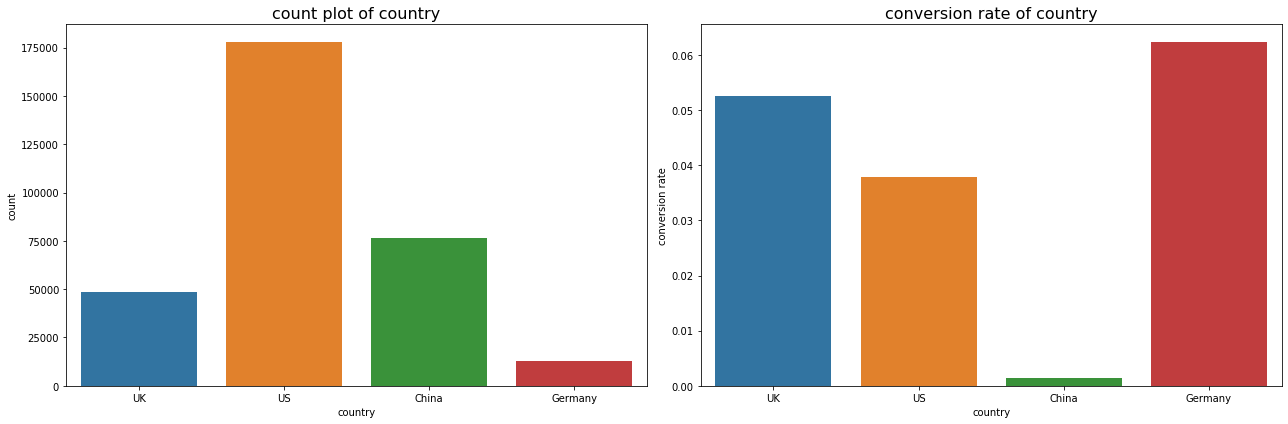

In [12]:
# Visualization of different countries
group_country = df[['country', 'converted']].groupby('country').mean().reset_index()

fig, ax = plt.subplots(1, 2, figsize = (18, 6))

sns.countplot(x = 'country', data = df, ax = ax[0])
ax[0].set_title('count plot of country', fontsize = 16)

sns.barplot(x = 'country', y = 'converted', data = group_country, ax = ax[1], order = ('UK', 'US', 'China', 'Germany'))
ax[1].set_xlabel('country')
ax[1].set_ylabel('conversion rate')
ax[1].set_title('conversion rate of country', fontsize = 16)

plt.tight_layout()

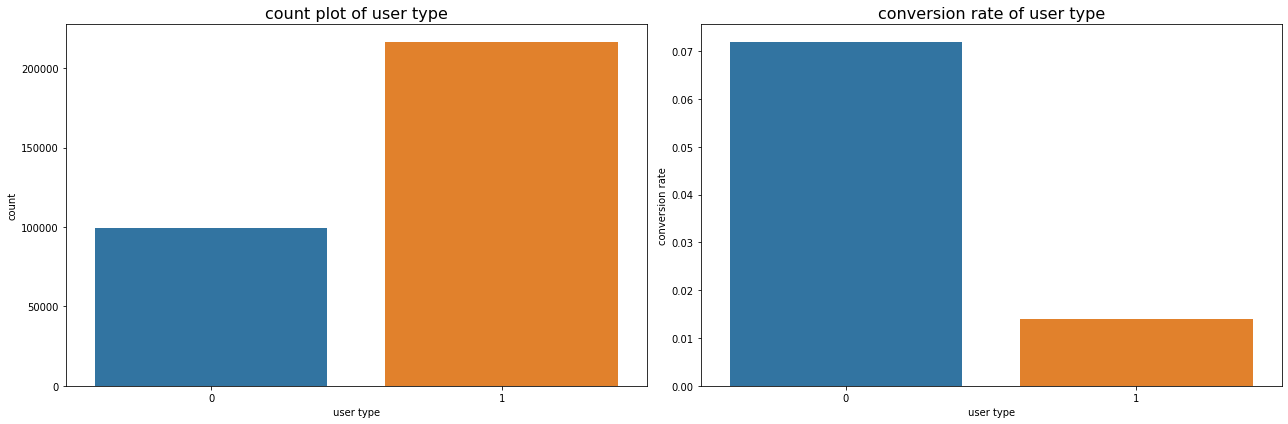

In [13]:
# Visualization of different user types
group_user = df[['new_user', 'converted']].groupby('new_user').mean().reset_index()

fig, ax = plt.subplots(1, 2, figsize = (18, 6))

sns.countplot(x = 'new_user', data = df, ax = ax[0])
ax[0].set_title('count plot of user type', fontsize = 16)
ax[0].set_xlabel('user type')

sns.barplot(x = 'new_user', y = 'converted', data = group_user, ax = ax[1])
ax[1].set_xlabel('user type')
ax[1].set_ylabel('conversion rate')
ax[1].set_title('conversion rate of user type', fontsize = 16)

plt.tight_layout()

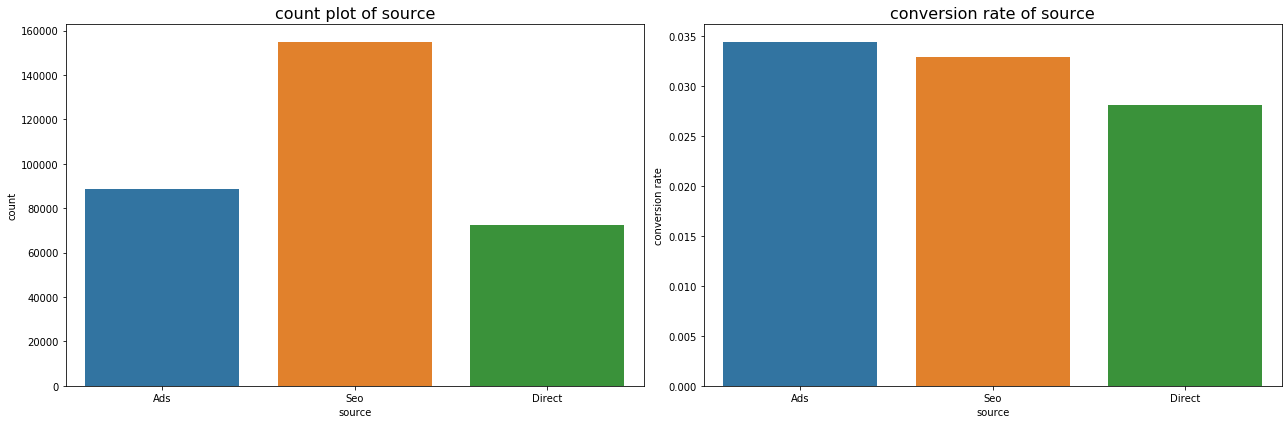

In [14]:
# Visualization of different sources
group_source = df[['source', 'converted']].groupby('source').mean().reset_index()

fig, ax = plt.subplots(1, 2, figsize = (18, 6))

sns.countplot(x = 'source', data = df, ax = ax[0])
ax[0].set_title('count plot of source', fontsize = 16)
ax[0].set_xlabel('source')

sns.barplot(x = 'source', y = 'converted', data = group_source, ax = ax[1], order = ('Ads', 'Seo', 'Direct'))
ax[1].set_xlabel('source')
ax[1].set_ylabel('conversion rate')
ax[1].set_title('conversion rate of source', fontsize = 16)

plt.tight_layout()

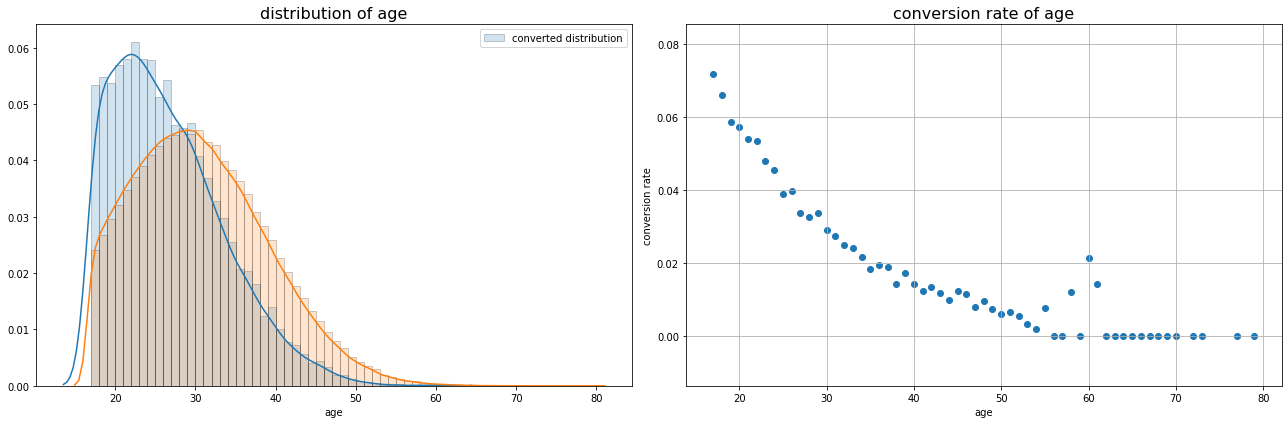

In [18]:
# Visualization of different ages
group_age = df[['age', 'converted']].groupby('age').mean().reset_index()

fig, ax = plt.subplots(1, 2, figsize = (18, 6))
hist_kws = {'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

sns.distplot(df[df['converted'] == 1]['age'], ax = ax[0], label = 'converted distribution', 
             bins = np.arange(df[df['converted'] == 1]['age'].min(), 
                              df[df['converted'] == 1]['age'].max() + 1), 
             hist_kws = hist_kws)
ax[0].set_title('distribution of age', fontsize = 16)
ax[0].legend()

sns.distplot(df['age'], ax = ax[0], label = 'total distribution', 
             bins = np.arange(df['age'].min(), df['age'].max() + 1),
             hist_kws = hist_kws)
ax[1].scatter(group_age['age'], group_age['converted'])
ax[1].set_title('conversion rate of age', fontsize = 16)
ax[1].set_xlabel('age')
ax[1].set_ylabel('conversion rate')
ax[1].grid(True)

plt.tight_layout()

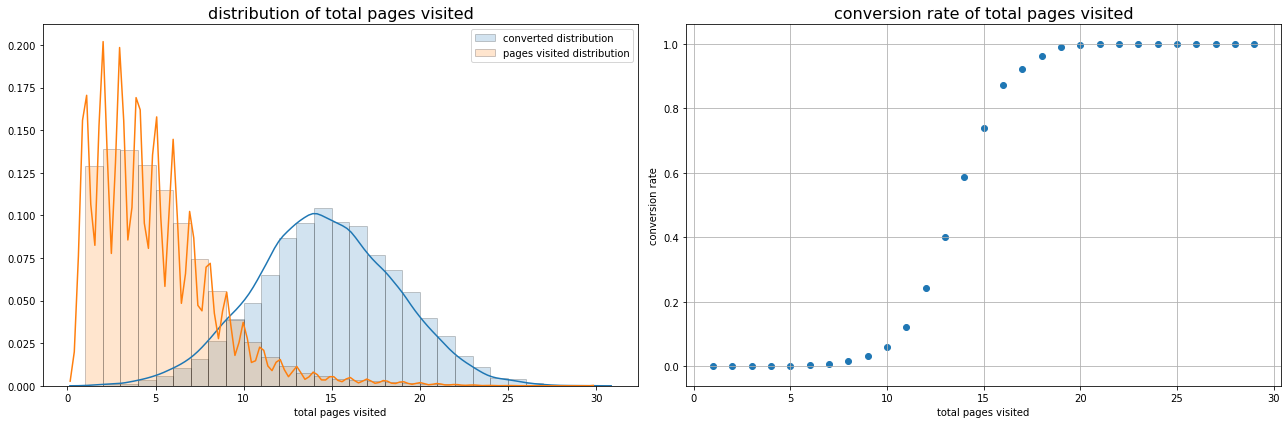

In [21]:
# Visualization of different pages visited
group_pageview = df[['total_pages_visited', 'converted']].groupby('total_pages_visited').mean().reset_index()

fig, ax = plt.subplots(1, 2, figsize = (18, 6))
hist_kws = {'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

sns.distplot(df[df['converted'] == 1]['total_pages_visited'], ax = ax[0], label = 'converted distribution', 
             bins = np.arange(df[df['converted'] == 1]['total_pages_visited'].min(), 
                              df[df['converted'] == 1]['total_pages_visited'].max() + 1), 
             hist_kws = hist_kws)
sns.distplot(df['total_pages_visited'], ax = ax[0], label = 'pages visited distribution', 
             bins = np.arange(df['total_pages_visited'].min(), df['total_pages_visited'].max() + 1),
             hist_kws = hist_kws)
ax[0].set_title('distribution of total pages visited', fontsize = 16)
ax[0].set_xlabel('total pages visited')
ax[0].legend()

ax[1].scatter(group_pageview['total_pages_visited'], group_pageview['converted'])
ax[1].set_title('conversion rate of total pages visited', fontsize = 16)
ax[1].set_xlabel('total pages visited')
ax[1].set_ylabel('conversion rate')
ax[1].grid(True)

plt.tight_layout()

# Machine Learning

### I am going to pick a random forest to predict conversion rate. I pick a random forest cause: it usually requires very little time to optimize it (its default params are often close to the best ones) and it is strong with outliers, irrelevant variables, continuous and discrete variables. I will use the random forest to predict conversion, then I will use its partial dependence plots and variable importance to get insights about how it got information from the variables.

In [1]:
# Initialize H2O cluster
h2o.init()

# clean slate, in case cluster was already running
h2o.remove_all()

NameError: name 'h2o' is not defined

In [23]:
# Transform to H2O Frame
h2o_df = H2OFrame(df)
h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,country,age,new_user,source,total_pages_visited,converted
type,enum,int,int,enum,int,int
mins,,17.0,0.0,,1.0,0.0
mean,,30.56931100133461,0.6854692313044358,,4.872918234777001,0.03225194340255157
maxs,,79.0,1.0,,29.0,1.0
sigma,,8.268957596421435,0.4643294585705555,,3.3410533442156285,0.17666876990331662
zeros,,0,99454,,0,306000
missing,0,0,0,0,0,0
0,UK,25.0,1.0,Ads,1.0,0.0
1,US,23.0,1.0,Seo,5.0,0.0
2,US,28.0,1.0,Seo,4.0,0.0


In [28]:
# Make sure the target variable is categorical
h2o_df['new_user'] = h2o_df['new_user'].asfactor()
h2o_df['converted'] = h2o_df['converted'].asfactor()

# feature = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
# target = 'converted'
feature = h2o_df.col_names[:-1]
target = h2o_df.col_names[-1]

# Split into 70% training and 30% test dataset
train, test = h2o_df.split_frame([0.7], seed = 12)

In [35]:
# Build random forest model
model = H2ORandomForestEstimator(ntrees = 100, max_depth = 20, 
                                 mtries = -1, seed = 34, score_each_iteration = True)
model.train(x = feature, y = target, training_frame = train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [38]:
model

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1568858422246_405


Model Summary: 

,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,100.0,100.0,2489508.0,19.0,20.0,19.95,708.0,2397.0,1975.87




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.012018941372911485
RMSE: 0.10963093255514834
LogLoss: 0.04846777902334937
Mean Per-Class Error: 0.07524596395134109
AUC: 0.9753284407265195
pr_auc: 0.7579285877431078
Gini: 0.950656881453039

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38102425994115574: 

,,0,1,Error,Rate
0,0,212889.0,1448.0,0.0068,(1448.0/214337.0)
1,1,1984.0,5141.0,0.2785,(1984.0/7125.0)
2,Total,214873.0,6589.0,0.0155,(3432.0/221462.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.381024,0.749745,185.0
1,max f2,0.201844,0.763369,245.0
2,max f0point5,0.672770,0.806144,108.0
3,max accuracy,0.505624,0.985085,152.0
4,max precision,0.999865,0.990683,0.0
5,max recall,0.000087,1.000000,399.0
6,max specificity,0.999865,0.999986,0.0
7,max absolute_mcc,0.396023,0.742637,181.0
8,max min_per_class_accuracy,0.017626,0.919300,355.0
9,max mean_per_class_accuracy,0.036887,0.924754,333.0



Gains/Lift Table: Avg response rate:  3.22 %, avg score:  3.22 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010002,0.965732,29.987837,29.987837,0.964786,0.987346,0.964786,0.987346,0.299930,0.299930,2898.783693,2898.783693
1,,2,0.020003,0.726714,25.974490,27.981164,0.835666,0.875203,0.900226,0.931275,0.259789,0.559719,2497.449048,2698.116371
2,,3,0.030001,0.373781,16.481807,24.149199,0.530262,0.541596,0.776942,0.801421,0.164772,0.724491,1548.180719,2314.919873
3,,4,0.040002,0.186409,7.577647,20.005843,0.243792,0.271875,0.643639,0.669020,0.075789,0.800281,657.764714,1900.584318
4,,5,0.050004,0.109736,3.943183,16.793021,0.126862,0.141348,0.540275,0.563476,0.039439,0.839719,294.318305,1579.302106
5,,6,0.100004,0.020597,1.518610,9.156160,0.048858,0.047757,0.294577,0.305628,0.075930,0.915649,51.861021,815.616047
6,,7,0.150003,0.006749,0.687726,6.333434,0.022126,0.012334,0.203763,0.207866,0.034386,0.950035,-31.227449,533.343379
7,,8,0.200003,0.003886,0.305968,4.826601,0.009844,0.004979,0.155284,0.157146,0.015298,0.965333,-69.403232,382.660128
8,,9,0.300006,0.001838,0.143153,3.265428,0.004606,0.002643,0.105057,0.105644,0.014316,0.979649,-85.684728,226.542827
9,,10,0.400001,0.001352,0.057547,2.463503,0.001851,0.001561,0.079257,0.079625,0.005754,0.985404,-94.245302,146.350321




Scoring History: 

,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-09-18 19:11:16,0.045 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-09-18 19:11:16,0.242 sec,1.0,0.119201,0.267520,0.909326,0.300961,24.339716,0.016668
2,,2019-09-18 19:11:17,0.405 sec,2.0,0.118249,0.249244,0.902563,0.359956,27.333202,0.016315
3,,2019-09-18 19:11:17,0.548 sec,3.0,0.116248,0.220623,0.916179,0.375199,27.208696,0.016327
4,,2019-09-18 19:11:17,0.838 sec,4.0,0.115667,0.194745,0.918647,0.409229,27.627322,0.016046
5,,2019-09-18 19:11:17,1.180 sec,5.0,0.115125,0.181209,0.922562,0.413605,28.028548,0.016141
6,,2019-09-18 19:11:18,1.556 sec,6.0,0.114722,0.174061,0.924964,0.421411,28.207083,0.016363
7,,2019-09-18 19:11:18,1.874 sec,7.0,0.114240,0.161969,0.929647,0.444155,28.381765,0.016094
8,,2019-09-18 19:11:18,2.182 sec,8.0,0.114009,0.154747,0.930233,0.453240,28.518890,0.016062
9,,2019-09-18 19:11:19,2.509 sec,9.0,0.113715,0.146681,0.932418,0.460180,28.691433,0.016477



See the whole table with table.as_data_frame()

Variable Importances: 

,variable,relative_importance,scaled_importance,percentage
0,total_pages_visited,298643.437500,1.000000,0.831069
1,age,24509.814453,0.082070,0.068206
2,new_user,15151.931641,0.050736,0.042165
3,country,14582.711914,0.048830,0.040581
4,source,6460.641602,0.021633,0.017979


In [37]:
# Make predictions
train_true = train.as_data_frame()['converted'].values
test_true = test.as_data_frame()['converted'].values

train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [39]:
# Classification report
print(classification_report(y_true = test_true, y_pred = (test_pred > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     91663
           1       0.84      0.68      0.75      3073

    accuracy                           0.99     94736
   macro avg       0.91      0.84      0.87     94736
weighted avg       0.98      0.99      0.98     94736



### So, train error and test error are pretty similar: 1.5% and 1%. We are confident we are not overfitting. Error is pretty low. However, we started from a 97% accuracy (that’s the case if we classified everything as 'non converted'). So, 99% is good, but nothing shocking.

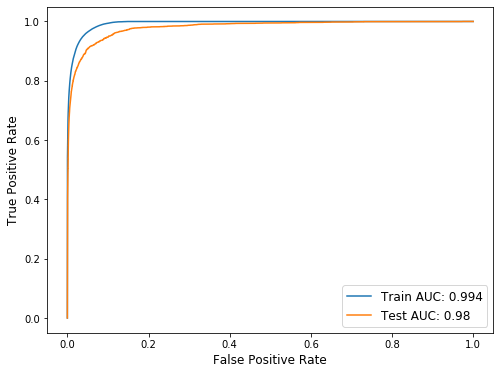

In [48]:
# Plot ROC, AUC
train_fpr, train_tpr, train_thresholds = roc_curve(train_true, train_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)

### AUC for both train dataset and test dataset are close to 1, which represents that the model has a good prediction even with imbalanced classes dataset.

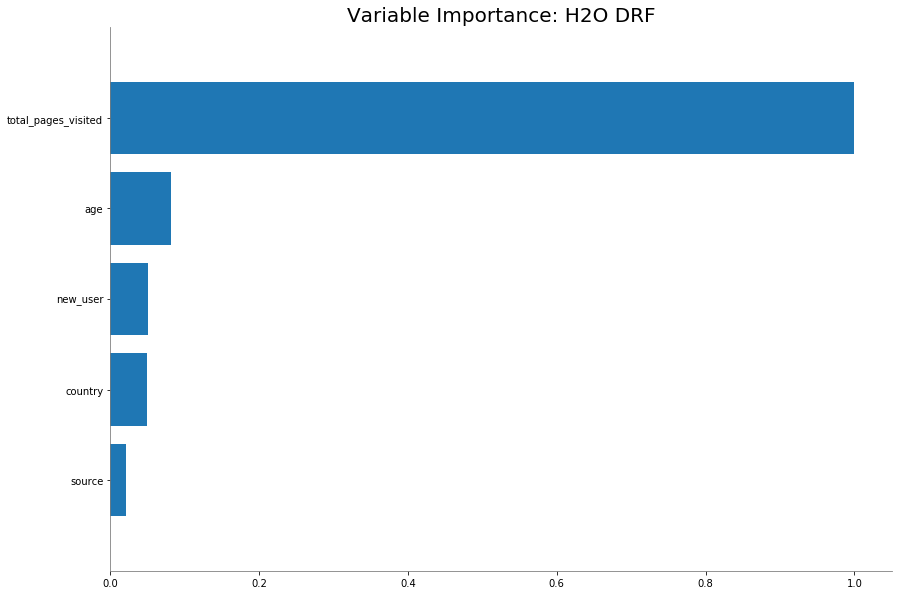

In [43]:
model.varimp_plot()

### Total pages visited is the most important one, by far. Unfortunately, it is probably the least “actionable”. People visit many pages cause they already want to buy. Also, in order to buy you have to click on multiple pages.

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


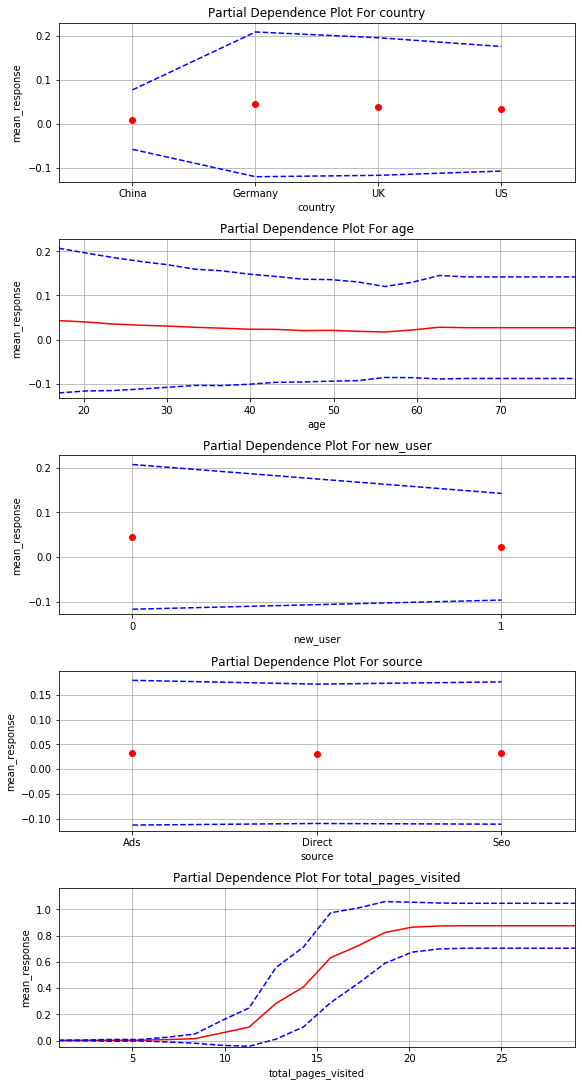

In [42]:
# Plot partial dependence plots
_ = model.partial_plot(train, cols = feature, figsize=(8, 15))

### This shows that:

1. Users with an old account are much better than new users
2. China is really bad, all other countries are similar with Germany being the best
3. The site works very well for young people and bad for less young people (>30 yrs old) 
4. Source is irrelevant

In [ ]:
# Shutdown h2o instance
h2o.cluster().shutdown()

# Some conclusions and suggestions:

1. The site is working very well for young users. Definitely let’s tell marketing to advertise and use marketing channel which are more likely to reach young people.

2. The site is working very well for Germany in terms of conversion. But the summary showed that there are few Germans coming to the site: way less than UK, despite a larger population. Again, marketing should get more Germans. Big opportunity.

3. Users with old accounts do much better. Targeted emails with offers to bring them back to the site could be a good idea to try.

4. Something is wrong with the Chinese version of the site. It is either poorly translated, doesn’t fit the local culture, some payment issue or maybe it is just in English! Given how many users are based in China, fixing this should be a top priority. Huge opportunity.

5. Maybe go through the UI and figure out why older users perform so poorly? From 30 y/o conversion clearly starts dropping.

6. If I know someone has visited many pages, but hasn’t converted, she almost surely has high purchase intent. I could email her targeted offers or sending her reminders. Overall, these are probably the easiest users to make convert.